<a href="https://colab.research.google.com/github/miruthiga/data-science/blob/main/data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

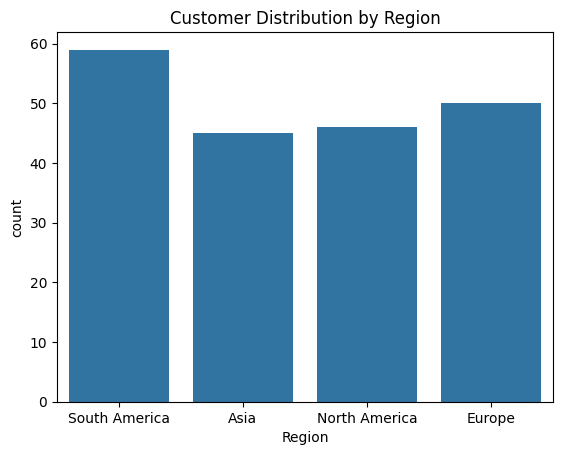

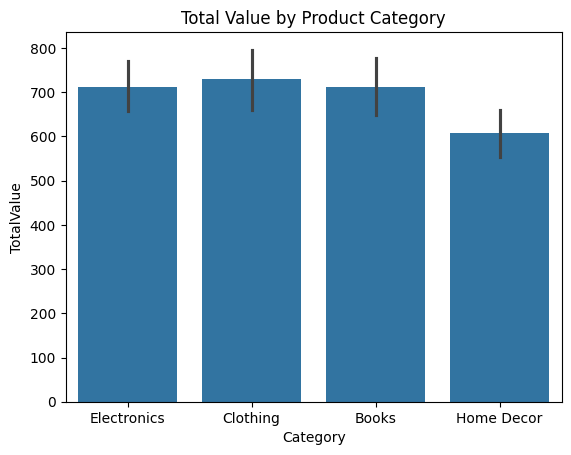

Davies-Bouldin Index: 0.725842659993461


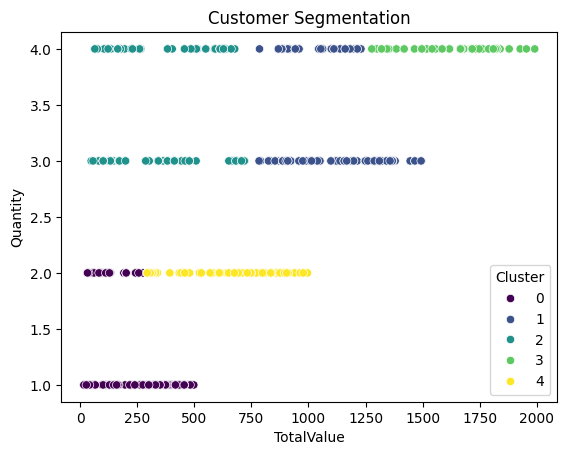

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import numpy as np

# Load datasets
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Task 1: Exploratory Data Analysis (EDA)
# Basic exploration
print(customers.info())
print(products.info())
print(transactions.info())

# Merge datasets for analysis
merged_data = pd.merge(transactions, customers, on='CustomerID')
merged_data = pd.merge(merged_data, products, on='ProductID')

# Summary statistics
print(merged_data.describe())

# Visualizations
sns.countplot(x='Region', data=customers)
plt.title('Customer Distribution by Region')
plt.show()

sns.barplot(x='Category', y='TotalValue', data=merged_data)
plt.title('Total Value by Product Category')
plt.show()

# Task 2: Lookalike Model
# Preprocess customer profiles and transactions
customer_profiles = customers.merge(transactions, on='CustomerID').merge(products, on='ProductID')

# Feature extraction (e.g., combining textual and numerical features)
customer_profiles['Profile'] = customer_profiles[['Region', 'Category']].apply(lambda x: ' '.join(x), axis=1)

# Compute similarity using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(customer_profiles['Profile'])
similarities = cosine_similarity(tfidf_matrix)

# Generate lookalike recommendations
lookalikes = {}
customer_ids = customers['CustomerID'].tolist()

for i, customer_id in enumerate(customer_ids[:20]):  # First 20 customers
    # Ensure the similarity matrix indices match customer_ids
    similar_indices = [j for j in np.argsort(-similarities[i])[1:] if j < len(customer_ids)][:3]  # Top 3 similar indices
    lookalikes[customer_id] = [(customer_ids[j], similarities[i][j]) for j in similar_indices]

# Save to CSV
lookalike_df = pd.DataFrame.from_dict(lookalikes, orient='index', columns=['Lookalike_1', 'Lookalike_2', 'Lookalike_3'])
lookalike_df.to_csv('FirstName_LastName_Lookalike.csv', index_label='CustomerID')

# Task 3: Customer Segmentation / Clustering
# Feature preparation
features = customer_profiles[['TotalValue', 'Quantity']]  # Add relevant features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Change n_clusters as needed
clusters = kmeans.fit_predict(scaled_features)
customer_profiles['Cluster'] = clusters

# Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")

# Visualization
sns.scatterplot(x='TotalValue', y='Quantity', hue='Cluster', data=customer_profiles, palette='viridis')
plt.title('Customer Segmentation')
plt.show()
